In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.DeepEnsemble.regression import EnsembleRegressor
from src.utils import set_seed

In [104]:
def get_xy(n_samples: int, eps: float = 1e-3, bound=[-4.0, 4.0]):
    # sample y = x^3 + noise, noise ~ N(0, eps^2)
    # The toy dataset used in the 'Deep ensemble' paper
    x = np.random.uniform(low=bound[0], high=bound[1], size=(n_samples, 1))
    x = torch.tensor(x).float()
    y = x ** 3 + torch.randn(size=(n_samples, 1)) * eps
    return x, y


def draw_band(ax, x: float, mean: float, std: float, label: str,
              z: float = 1.0, color='C0'):
    ax.plot(x, mean, color=color, label='{} mean'.format(label))
    ax.fill_between(x, mean - z * std, mean + z * std,
                    alpha=0.2, color=color, label='{} CI'.format(label))

In [113]:
# set random seeds; for reproducibility
set_seed(1234, use_cuda=torch.cuda.is_available())
eps = 1e-2
bound = [-6.0, 6.0]
train_val_ratio = 0.8
n_samples = 32

x, y = get_xy(n_samples=n_samples, eps=eps, bound=bound)
n_train = math.ceil(x.shape[0] * train_val_ratio)
train_x, train_y = x[:n_train, :], y[:n_train, :]
val_x, val_y = x[n_train:, :], y[n_train:, :]

In [114]:
MDN_INDIM = 64
DEVICE = 'cuda:0'
BATCH_SIZE = 64

learner_config = {
    'mlp_config': {'input_dim': 1,
                   'output_dim': MDN_INDIM,
                   'num_neurons': [],
                   'out_act': 'ReLU'},
    'mdn_config': {'input_dim': MDN_INDIM, 'output_dim': 1, 'num_gaussians': 1},
    'opt_config': {'name': 'Adam', 'lr': 1e-1}
}

net = EnsembleRegressor(5, learner_config).to(DEVICE)

train_data = (train_x, train_y)
val_data = (val_x, val_y)

In [115]:
fit_config = {
    'parallel': False,
    'batch_size': BATCH_SIZE,
    'val_batch_size': n_samples,
    'device': DEVICE,
    'epochs': 128,
    'validate_every': 30,
    'adv_eps': (bound[1] - bound[0]) * 0.000
}

_ = net.fit(train_data=train_data,
            fit_config=fit_config,
            val_data=val_data)

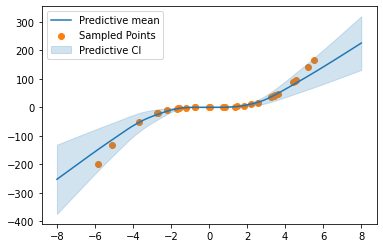

In [116]:
test_x = torch.linspace(-8.0, 8.0, 100).view(-1, 1)
with torch.no_grad():
    test_mu, test_sigma = net(test_x)

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, label='Sampled Points', color='C1')
draw_band(ax, test_x.view(-1), test_mu.view(-1), test_sigma.view(-1), 'Predictive')
ax.legend()
plt.show()



